In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime
from collections import Counter
import math

In [3]:
path = "train.csv"
df = pd.read_csv(path)
df.dropna(subset=['rain_sum (mm)'], axis=0, inplace=True)
df = df.reset_index().drop(columns='index')
df.head()

,time,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,6.9,20.2,277.0,3.61,0,su
1,2018-01-02,30.6,25.7,37.7,31.2,2018-01-02T05:15,2018-01-02T17:50,19.87,9.4,0.0,7.1,18.0,168.0,4.11,0,su
2,2018-01-03,31.8,25.9,40.3,31.7,2018-01-03T05:16,2018-01-03T17:50,20.44,7.8,0.0,8.1,21.2,125.0,4.23,0,su
3,2018-01-04,30.8,26.0,39.1,31.6,2018-01-04T05:16,2018-01-04T17:50,20.44,29.7,0.0,7.2,21.6,190.0,4.22,0,su
4,2018-01-05,30.9,25.2,37.6,29.9,2018-01-05T05:17,2018-01-05T17:51,20.10,22.5,0.0,6.9,21.2,241.0,4.16,0,su


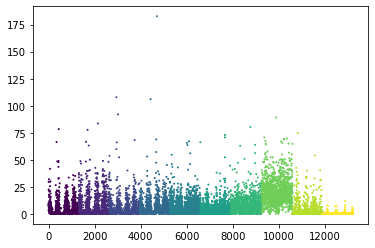

In [20]:
uniqcity = Counter(df.city)
mapping = {}
for i,city in enumerate(uniqcity):
    mapping[city] = i
colorlist = list(map(mapping.get, df.city))
plt.scatter(df.index,df.iloc[:,8],c=colorlist,s=1)

In [5]:
avg_wind_percity = []
avg_wind = df[['winddirection_10m_dominant (°)','city']].groupby(by='city').mean()

for city in uniqcity :
    index_range = df.loc[df['city'] == city].index
    # validnum = sum(map(lambda x : not math.isnan(df.iloc[x,12]), index_range))
    avg_wind_percity = avg_wind.loc[city][0]
    for i in index_range :
        df.iloc[i,12] = avg_wind_percity if math.isnan(df.iloc[i,12]) else df.iloc[i,12]
    

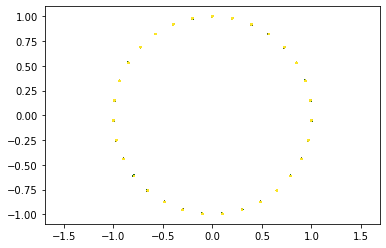

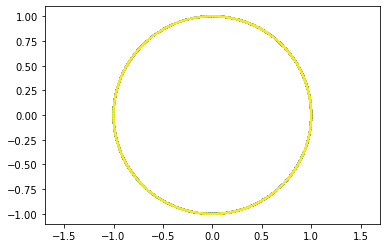

In [44]:
cols = df.columns
df[cols[0]] = df[cols[0]].astype('string')
#encode date
yearis = []
monthis = []
dayis = []
for row in df.index :
    yearis.append(int(df[cols[0]][row].split('-')[0]))
    monthis.append(int(df[cols[0]][row].split('-')[1]))
    dayis.append(int(df[cols[0]][row].split('-')[2])) 

min(yearis),min(monthis),min(dayis)
mincount  = min(yearis)*365 + min(monthis)*30 + min(dayis)*1

daysince = []
for row in df.index :
    dateval = yearis[row]*365 + monthis[row]*30 + dayis[row]*1
    datecount = dateval-mincount
    daysince.append(datecount)

maxday = max(dayis)
maxdmo = max(dayis)*max(monthis)
dayval = pd.Series(daysince)

sinday = np.sin(2*np.pi*dayval/maxday)
cosday = np.cos(2*np.pi*dayval/maxday)
sindmo = np.sin(2*np.pi*dayval/maxdmo)
cosdmo = np.cos(2*np.pi*dayval/maxdmo)

plt.scatter(sinday,cosday,c=colorlist,s=1)
plt.axis('equal')
plt.show()
plt.scatter(sindmo,cosdmo,c=colorlist,s=1)
plt.axis('equal')
plt.show()

In [75]:
dateset = pd.DataFrame({'daysince': daysince, 'sinday': sinday, 'cosday': cosday, 'sindmo': sindmo, 'cosdmo': cosdmo, 'year' : yearis})

In [56]:
rise = df['sunrise (iso8601)']
set = df['sunset (iso8601)']

In [57]:
#encode rise and set
riseencode = []
setencode = []
validrise = []
validset = []

risehour = []
risemin = []
riseval = []
sethour = []
setmin = []
setval = []

for row in df.index :
    riseencode.append(datetime.fromisoformat(rise[row]).strftime("%m:%d:%Y:%H:%M:%S"))
    setencode.append(datetime.fromisoformat(set[row]).strftime("%m:%d:%Y:%H:%M:%S"))
    validrise.append(True) if '01:01:1970' in riseencode[row] else validrise.append(False)
    validset.append(True) if '01:01:1970' in setencode[row] else validset.append(False)

    if validrise[row] == False :
        riseencode[row] = riseencode[row][-8:].split(':')
    else :
        riseencode[row] = '00:00:00'.split(':')

    if validset[row] == False :
        setencode[row] = setencode[row][-8:].split(':')
    else :
        setencode[row] = '00:00:00'.split(':')
    
    risehour.append(int(riseencode[row][0]))
    risemin.append(int(riseencode[row][1]))

    sethour.append(int(setencode[row][0]))
    setmin.append(int(setencode[row][1]))

    riseval.append(risehour[row]*60 + risemin[row])
    setval.append(sethour[row]*60 + setmin[row])

In [61]:
index_range = df.loc[df['city'] == 'q'].index
validnum = sum(map(lambda x: riseval[x] != 0, index_range))

avgrise = sum(riseval[min(index_range):max(index_range)])//validnum
avgset = sum(setval[min(index_range):max(index_range)])//validnum

for row in df.index :
    riseval[row] = avgrise if riseval[row] == 0 else riseval[row]
    setval[row] = avgset if setval[row] == 0 else setval[row]

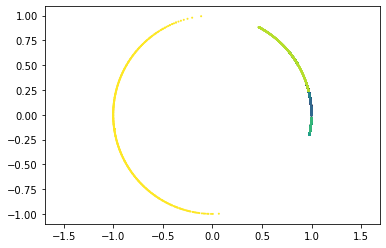

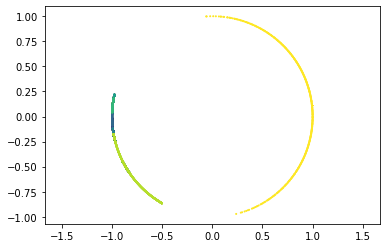

In [69]:
minperday = 24*60
riseval = pd.Series(riseval)
setval = pd.Series(setval)

sinrise = np.sin(2*np.pi*riseval/minperday)
cosrise = np.cos(2*np.pi*riseval/minperday)
sinset = np.sin(2*np.pi*setval/minperday)
cosset = np.cos(2*np.pi*setval/minperday)

plt.scatter(sinrise,cosrise,c=colorlist,s=1)
plt.axis('equal')
plt.show()
plt.scatter(sinset,cosset,c=colorlist,s=1)
plt.axis('equal')
plt.show()

In [76]:
riseset = pd.DataFrame({'sinrise': sinrise, 'cosrise': cosrise, 'sinset': sinset, 'cosset': cosset })
addset = dateset.join(riseset)
addset

,daysince,sinday,cosday,sindmo,cosdmo,year,sinrise,cosrise,sinset,cosset
0,0,0.000000,1.000000,0.000000,1.000000,2018,0.980785,0.195090,-0.998848,-0.047978
1,1,0.201299,0.979530,0.016889,0.999857,2018,0.980785,0.195090,-0.999048,-0.043619
2,2,0.394356,0.918958,0.033774,0.999429,2018,0.981627,0.190809,-0.999048,-0.043619
3,3,0.571268,0.820763,0.050649,0.998717,2018,0.981627,0.190809,-0.999048,-0.043619
4,4,0.724793,0.688967,0.067510,0.997719,2018,0.982450,0.186524,-0.999229,-0.039260
...,...,...,...,...,...,...,...,...,...,...
13193,1304,0.394356,0.918958,-0.033774,-0.999429,2021,-0.990268,-0.139173,0.994056,0.108867
13194,1305,0.571268,0.820763,-0.050649,-0.998717,2021,-0.990268,-0.139173,0.994056,0.108867
13195,1305,0.571268,0.820763,-0.050649,-0.998717,2021,-0.990268,-0.139173,0.994056,0.108867
13196,1306,0.724793,0.688967,-0.067510,-0.997719,2021,-0.990268,-0.139173,0.994056,0.108867


In [81]:
newdf = df
newdf = pd.concat([newdf.drop(columns=['time','sunrise (iso8601)','sunset (iso8601)']), addset],axis=1)
newdf = pd.get_dummies(newdf, columns=['city'])
newdf.corr()['rain_sum (mm)'].sort_values().to_frame()

,rain_sum (mm)
windspeed_10m_max (km/h),-0.333069
shortwave_radiation_sum (MJ/m²),-0.256751
city_q,-0.217606
cosset,-0.205043
sinset,-0.200811
et0_fao_evapotranspiration (mm),-0.196993
city_sa,-0.137587
snowfall_sum (cm),-0.094655
city_lh,-0.076902
city_u,-0.065119


In [82]:
# newdf.to_csv('preproc1.csv')